# A. Introduction

Created by : Yuliana Theresa

# B. Problem Statement

As a professional working in the game development industry, I have been assigned the task of collecting and categorizing images of domestic animals—specifically dogs and cats—as well as various wild animals. These images will be used to develop a new game aimed at testing players' ability to accurately identify different animals.

The game concept is simple: players are presented with images and must guess whether the image depicts a cat, a dog, or a wild animal. A correct guess will reward the player with points and unlock subsequent levels. The challenge lies in ensuring that the game can efficiently and accurately distinguish between these three categories to provide a smooth and engaging player experience.

B.1 Goals

Given the relatively short timeline for this project, I plan to utilize a Convolutional Neural Network (CNN) to assist in the automatic classification of the images collected. CNNs are highly effective for image recognition tasks, making them an ideal choice for this project. By leveraging this deep learning model, the game will be able to accurately predict and categorize images into the correct categories—cats, dogs, or wild animals. The primary goal is to train the CNN to achieve a high degree of accuracy, ensuring that the game provides a reliable and enjoyable user experience.

-------

# C. Import Libraries

In [1]:
!pip install --upgrade "tensorflow<2.16" "tf-keras<2.16"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled ke

In [2]:
# Importing the Necessary Libraries

import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# D. Data Loading

In [3]:
# Download dataset image from https://www.kaggle.com/datasets/andrewmvd/animal-faces

!kaggle datasets download -d andrewmvd/animal-faces
!unzip animal-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train/wild/fl

In [4]:
# Create a Pandas DataFrame that contains the path of all images

image_paths = glob.glob('/content/afhq/train/*/*')
labels = [path.split('/')[-2] for path in image_paths]
img_df = pd.DataFrame({'images':image_paths, 'label':labels})
img_df.head(10)

images label
0   /content/afhq/train/wild/flickr_wild_003651.jpg  wild
1   /content/afhq/train/wild/flickr_wild_001117.jpg  wild
2   /content/afhq/train/wild/flickr_wild_002099.jpg  wild
3   /content/afhq/train/wild/flickr_wild_001476.jpg  wild
4   /content/afhq/train/wild/flickr_wild_003430.jpg  wild
5  /content/afhq/train/wild/pixabay_wild_000642.jpg  wild
6  /content/afhq/train/wild/pixabay_wild_000353.jpg  wild
7   /content/afhq/train/wild/flickr_wild_000678.jpg  wild
8   /content/afhq/train/wild/flickr_wild_001528.jpg  wild
9   /content/afhq/train/wild/flickr_wild_002171.jpg  wild

There are approximately 16,000 image data taken from Kaggle but here I will only take 500 images per class to make it easier while processing the data

In [5]:
# Sampling 500 images for each categories

cat = img_df[img_df['label'] == 'cat'].sample(1500)
dog = img_df[img_df['label'] == 'dog'].sample(1500)
wild = img_df[img_df['label'] == 'wild'].sample(1500)

In [6]:
# Check sampling

wild

images label
2904   /content/afhq/train/wild/flickr_wild_001141.jpg  wild
1235  /content/afhq/train/wild/pixabay_wild_000320.jpg  wild
1218   /content/afhq/train/wild/flickr_wild_000943.jpg  wild
642    /content/afhq/train/wild/flickr_wild_001973.jpg  wild
3466   /content/afhq/train/wild/flickr_wild_001935.jpg  wild
...                                                ...   ...
4513   /content/afhq/train/wild/flickr_wild_001150.jpg  wild
3567  /content/afhq/train/wild/pixabay_wild_000365.jpg  wild
2321  /content/afhq/train/wild/pixabay_wild_000446.jpg  wild
4123   /content/afhq/train/wild/flickr_wild_000323.jpg  wild
3473   /content/afhq/train/wild/flickr_wild_002523.jpg  wild

[1500 rows x 2 columns]

In [7]:
# Combining DataFrames

df_animal = pd.concat([cat, dog, wild]).reset_index(drop=True)
df_animal

images label
0       /content/afhq/train/cat/pixabay_cat_002353.jpg   cat
1        /content/afhq/train/cat/flickr_cat_000475.jpg   cat
2       /content/afhq/train/cat/pixabay_cat_003403.jpg   cat
3       /content/afhq/train/cat/pixabay_cat_002674.jpg   cat
4       /content/afhq/train/cat/pixabay_cat_004557.jpg   cat
...                                                ...   ...
4495   /content/afhq/train/wild/flickr_wild_001150.jpg  wild
4496  /content/afhq/train/wild/pixabay_wild_000365.jpg  wild
4497  /content/afhq/train/wild/pixabay_wild_000446.jpg  wild
4498   /content/afhq/train/wild/flickr_wild_000323.jpg  wild
4499   /content/afhq/train/wild/flickr_wild_002523.jpg  wild

[4500 rows x 2 columns]

In [8]:
df_animal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  4500 non-null   object
 1   label   4500 non-null   object
dtypes: object(2)
memory usage: 70.4+ KB


In [9]:
df_animal.dtypes

images    object
label     object
dtype: object

with two columns containing photos and labels of 600 photos, each of which is divided into 3 classes, next we will check each class

# E. Exploratory Data Analysis (EDA)

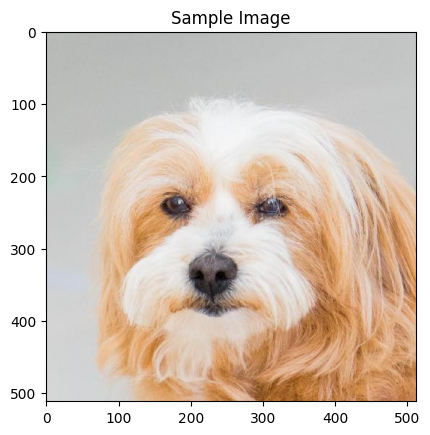

In [10]:
# Load and display a sample image
image_path = '/content/afhq/train/dog/flickr_dog_000002.jpg'
img = cv2.imread(image_path)

# Check if the image was loaded correctly
if img is None:
    print(f"Error: Could not load image at {image_path}. Check the file path and permissions.")
else:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Sample Image')
    plt.show()

This is a sample of one of the many photos representing one of the classes. Let's check each class

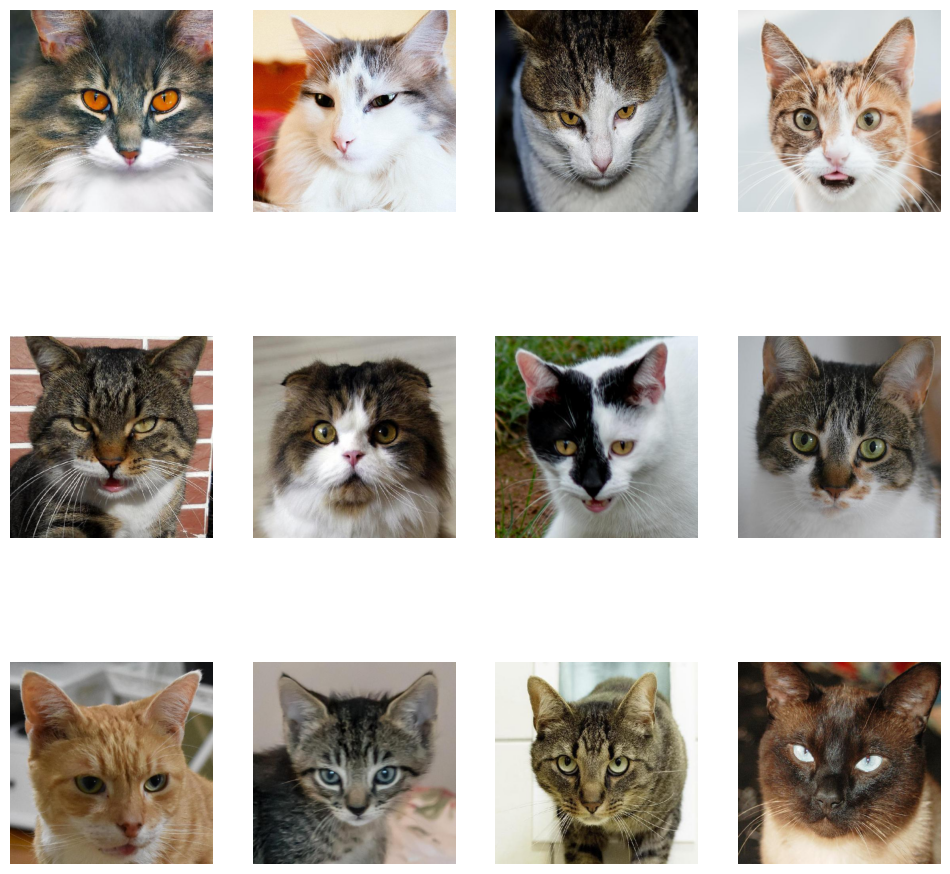

In [11]:
# Visualization class of 'Cat'

cat_path = df_animal[df_animal['label'] == 'cat']
plt.figure(figsize=(12, 12))
for i in range(12):
    img = cv2.imread(cat_path.iloc[i]['images'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

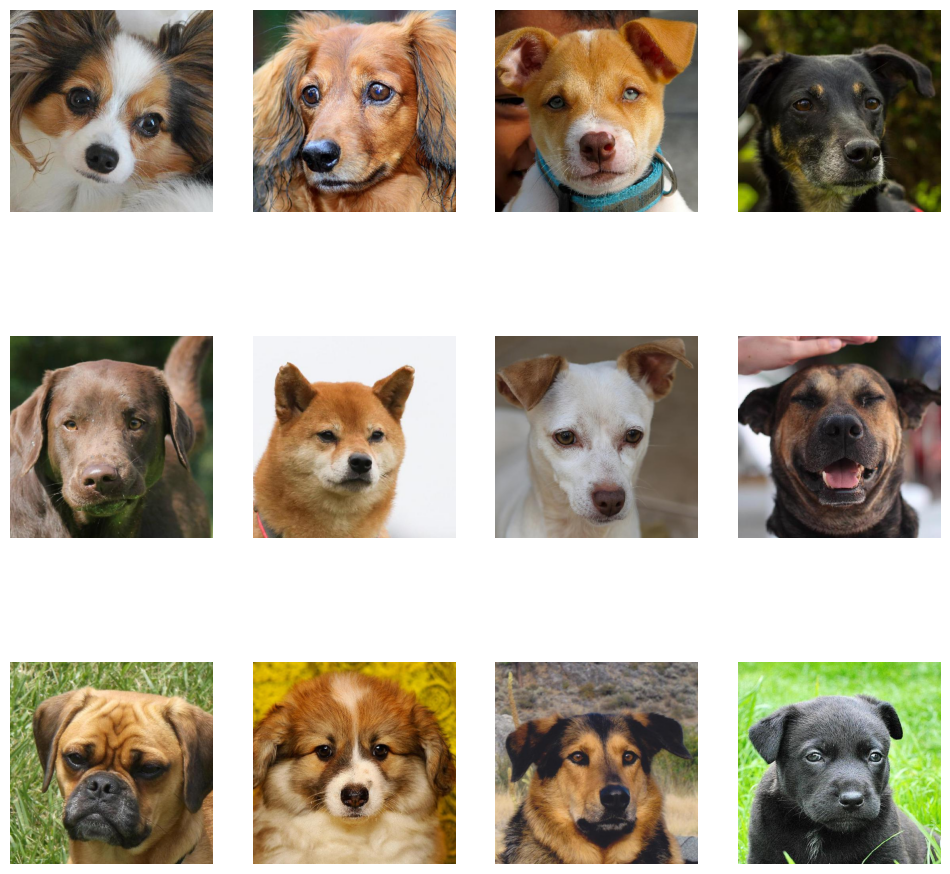

In [12]:
# Visualization class of 'Dog'

dog_path = df_animal[df_animal['label'] == 'dog']
plt.figure(figsize=(12, 12))
for i in range(12):
    img = cv2.imread(dog_path.iloc[i]['images'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

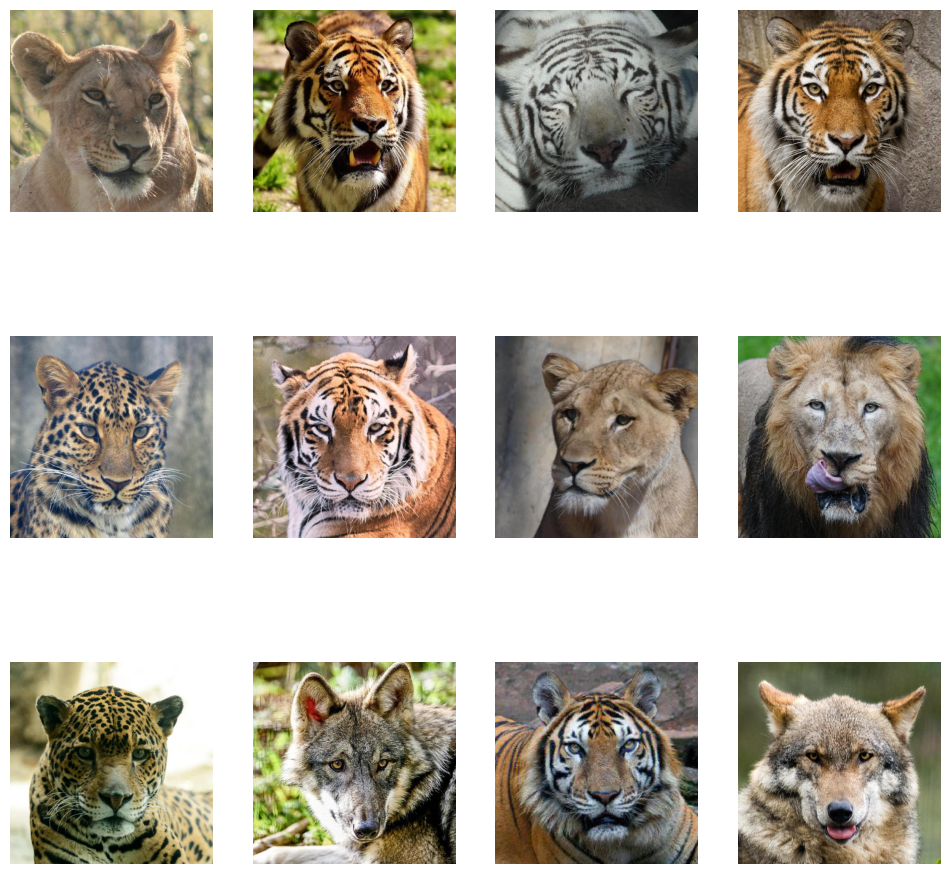

In [13]:
# Visualization class of 'Wild'

wild_path = df_animal[df_animal['label'] == 'wild']
plt.figure(figsize=(12, 12))
for i in range(12):
    img = cv2.imread(wild_path.iloc[i]['images'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

From each class we can see that the photos shown are always from the front and only the face or front view, so we cannot see other parts of the body

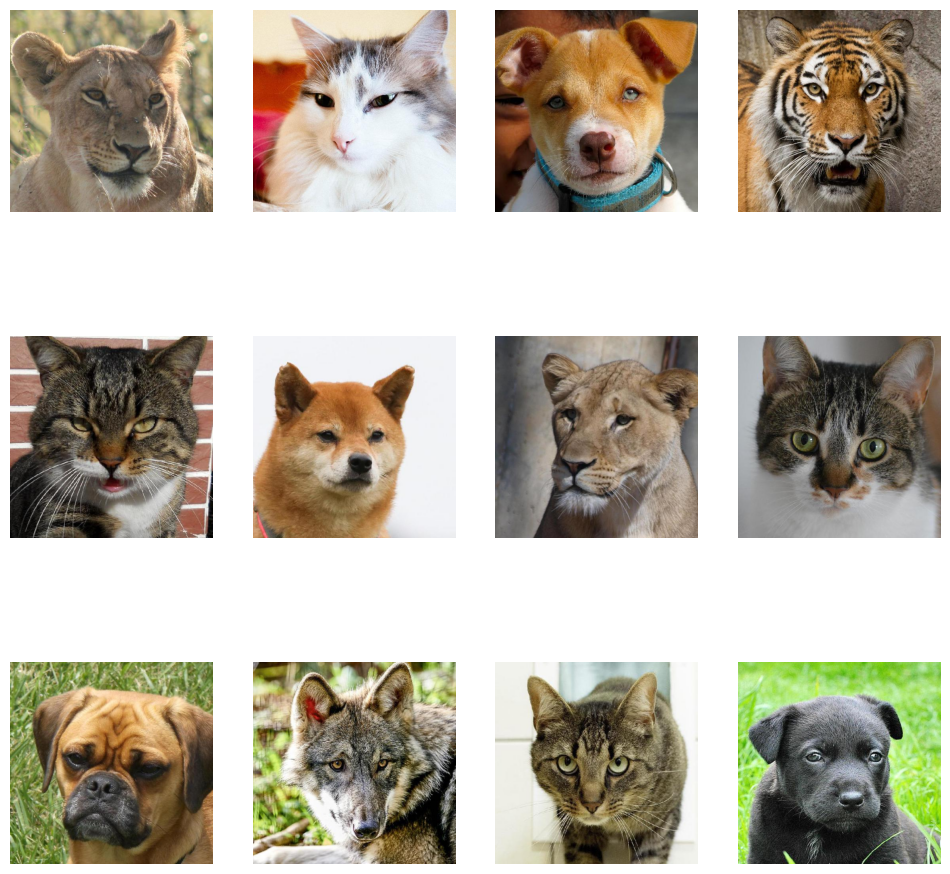

In [14]:
# Visualization all of classes

wild_path = df_animal[df_animal['label'] == 'wild']
cat_path = df_animal[df_animal['label'] == 'cat']
dog_path = df_animal[df_animal['label'] == 'dog']

paths = [wild_path, cat_path, dog_path]

plt.figure(figsize=(12, 12))
for i in range(12):
    df = paths[i % len(paths)]
    img = cv2.imread(df.iloc[i]['images'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

There is much picture that have similarity. Like the picture of some kind of cat and tiger (wild), they both have vertical stripes even the color is different. It was same as kind of dog and some of cat, they have same ear shape.

# F. Feature Engineering

## F.1 Feature Scalling

In [15]:
# Rescale Image

train_val_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
  )

In [16]:
val_gen = ImageDataGenerator(
    rescale=1./255,
  )

In [17]:
ImageDataGenerator(rescale=1./255,
                   )

## F.2 Split train, validation and test set

In [18]:
# Create Test Sample from DataFrame

cat_test_index = list(cat.sample(500).index)
dog_test_index = list(dog.sample(500).index)
wild_test_index = list(wild.sample(500).index)

In [19]:
# Create Train Val from test_index

cat_train_val = cat.drop(cat_test_index)
dog_train_val = dog.drop(dog_test_index)
wild_train_val = wild.drop(wild_test_index)

In [20]:
# Create data test from test_index

cat_test = cat.loc[cat_test_index]
dog_test = dog.loc[dog_test_index]
wild_test = wild.loc[wild_test_index]

In [21]:
# Split Train Set

img_train = train_val_gen.flow_from_dataframe(
    dataframe=pd.concat([cat_train_val, dog_train_val, wild_train_val], axis=0),
    x_col='images',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    subset='training'
)

Found 2400 validated image filenames belonging to 3 classes.


In [22]:
# Split Val Set

img_val = train_val_gen.flow_from_dataframe(
    dataframe=pd.concat([cat_train_val, dog_train_val, wild_train_val], axis=0),
    x_col='images',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    subset='validation'
)

Found 600 validated image filenames belonging to 3 classes.


In [23]:
# Split Test Set

img_test = train_val_gen.flow_from_dataframe(
    dataframe=pd.concat([cat_test, dog_test, wild_test], axis=0),
    x_col='images',
    y_col='label',
    target_size=(150, 150),
    batch_size=32
)

Found 1500 validated image filenames belonging to 3 classes.


For training the dataset there will be 2400 images, validation will be 600 images and the test will be 1500 images

# G. ANN Training (Sequential API)

## G.1 Model Definition

In [24]:
# Clear Session
seed = 42
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [25]:
# Create Sequential API

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, 2))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(512, activation='relu'))

# Output
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 64)                0         
 GlobalAveragePooling2D)                                         
                                                        

After create sequential API, we get that total paramaters is 54.211 to be trained in this model and all parameters in this model can be updated during training because there is zero non-trainable paramater in model summary

In [27]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

## G.2 Model Training

In [28]:
# Model Compile
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(img_train,
                    epochs=25,
                    validation_data = img_val,
                    verbose = 1)

Epoch 1/25
75/75 [==============================] - 13s 113ms/step - loss: 1.0160 - accuracy: 0.4638 - val_loss: 1.6328 - val_accuracy: 0.0000e+00
Epoch 2/25
75/75 [==============================] - 7s 91ms/step - loss: 0.9531 - accuracy: 0.5583 - val_loss: 1.7122 - val_accuracy: 0.0000e+00
Epoch 3/25
75/75 [==============================] - 7s 92ms/step - loss: 0.8464 - accuracy: 0.6388 - val_loss: 1.7657 - val_accuracy: 0.0133
Epoch 4/25
75/75 [==============================] - 8s 108ms/step - loss: 0.8215 - accuracy: 0.6608 - val_loss: 1.6706 - val_accuracy: 0.0067
Epoch 5/25
75/75 [==============================] - 7s 90ms/step - loss: 0.7755 - accuracy: 0.6775 - val_loss: 1.8804 - val_accuracy: 0.0433
Epoch 6/25
75/75 [==============================] - 11s 147ms/step - loss: 0.7644 - accuracy: 0.6817 - val_loss: 1.6068 - val_accuracy: 0.0400
Epoch 7/25
75/75 [==============================] - 7s 97ms/step - loss: 0.7235 - accuracy: 0.7033 - val_loss: 1.3801 - val_accuracy: 0.1483


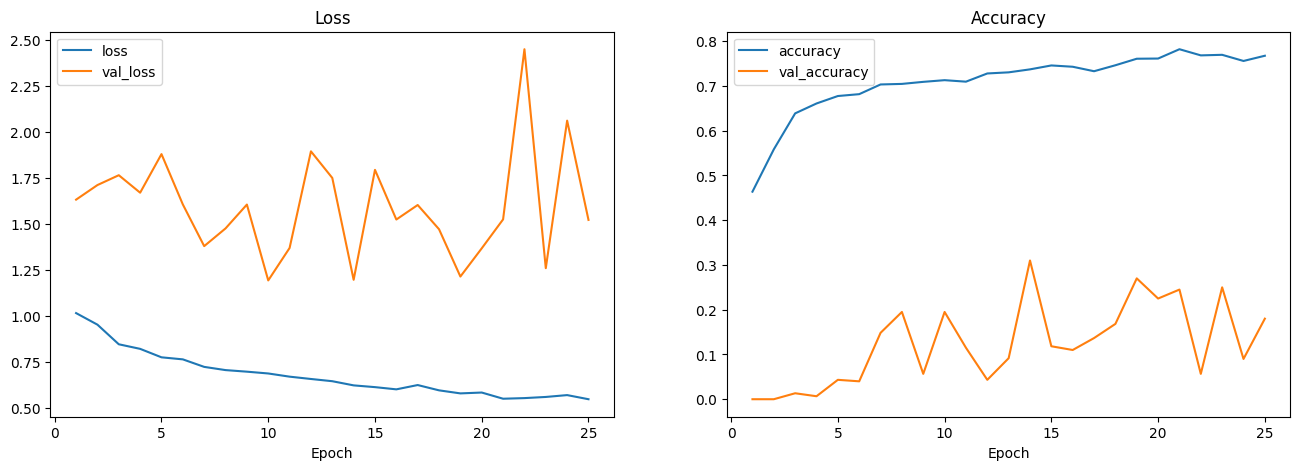

In [29]:
epoch=25

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),model.history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),model.history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,epoch+1),model.history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),model.history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

plt.show()

The results indicate that the model is overfitting because loss line on the plot shows a decrease line which means the model is getting better at learning the training data but loss on the validation data looks unstable and tends to remain high

So for the next step we need to improve the model

# H. ANN Improvement (Sequential API)

## H.1 Model Definition

In [30]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [31]:
# Download the Resnet50 Model
pretrained_model= tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(150, 150, 3)
)

# Freeze the Lower Layer
pretrained_model.trainable= False

94765736/94765736 [==============================] - 3s 0us/step


For improving the data, we will use ResNet which is superior rather than CNN because it introduces the concept of residual units, which allows deep layers to directly learn from shallow layers, reducing the difficulty of network convergence [resource](https://typeset.io/questions/why-is-resnet-superior-over-cnn-19q55sselq#). Hopefully this results will be better for learning ability and improved performance in image recognition tasks with Resnet50

In [32]:
# Create Sequential API
model_2 = Sequential()

# Add the RestNet Model
model_2.add(pretrained_model)
model_2.add(GlobalAveragePooling2D())
model_2.add(Dense(15, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_2.add(Dropout(0.1, seed=seed))
model_2.add(Dense(25, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_2.add(Dropout(0.1, seed=seed))
model_2.add(Dense(35, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))
model_2.add(Dropout(0.1, seed=seed))
model_2.add(Dense(45, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed)))

# Output
model_2.add(Dense(3, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotNormal(seed)))

Adding the drop out in this model to avoid overfitting when model training the dataset

## H.2 Model Training

In [33]:
# Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 15)                30735     
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                400       
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                        

In [34]:
# Train the Model
history_model_2 = model_2.fit(img_train,
                              epochs=35,
                              validation_data=img_val,
                              verbose=1)

Epoch 1/35
75/75 [==============================] - 19s 149ms/step - loss: 1.0529 - accuracy: 0.4125 - val_loss: 1.5594 - val_accuracy: 0.0000e+00
Epoch 2/35
75/75 [==============================] - 13s 169ms/step - loss: 1.0187 - accuracy: 0.4408 - val_loss: 1.5671 - val_accuracy: 0.0000e+00
Epoch 3/35
75/75 [==============================] - 9s 118ms/step - loss: 0.9977 - accuracy: 0.4712 - val_loss: 1.6389 - val_accuracy: 0.0000e+00
Epoch 4/35
75/75 [==============================] - 9s 118ms/step - loss: 0.9138 - accuracy: 0.5858 - val_loss: 1.6937 - val_accuracy: 0.0000e+00
Epoch 5/35
75/75 [==============================] - 8s 106ms/step - loss: 0.8270 - accuracy: 0.6363 - val_loss: 1.5532 - val_accuracy: 0.0000e+00
Epoch 6/35
75/75 [==============================] - 9s 120ms/step - loss: 0.7893 - accuracy: 0.6533 - val_loss: 1.4073 - val_accuracy: 0.0000e+00
Epoch 7/35
75/75 [==============================] - 9s 125ms/step - loss: 0.7626 - accuracy: 0.6683 - val_loss: 1.4438 - v

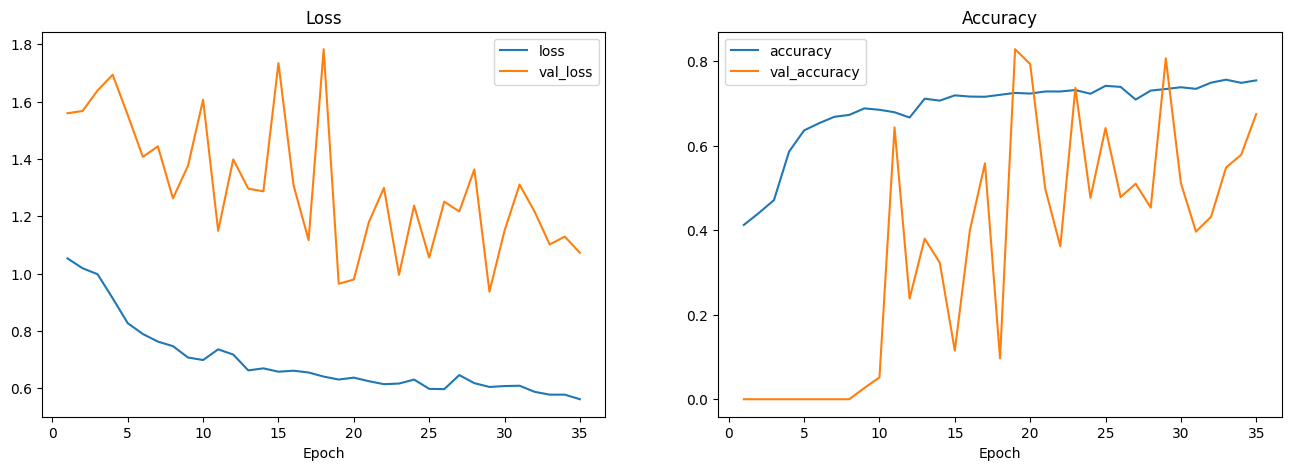

In [35]:
epoch=35

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),model_2.history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),model_2.history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),model_2.history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),model_2.history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

After improving the model, there is no big significant changes. However, validation loss show that model can learning data more better than before but still overfit when learning the dataset. In the other hand, we can see value of val_accuracy between before and after improving because after improving, value val_accuracy have significant changes

# I. Model Saving

In [36]:
# Freeze all layers
for layer in pretrained_model.layers:
    layer.trainable = False

In [37]:
# Save the model
model.save('model_cnn.h5')
model_2.save('model_resnet.h5')

# J. Model Inference

In [39]:
# Load the saved model cnn
model = keras.models.load_model('model_cnn.h5')

# Make predictions on the test set
predictions = model.predict(img_test)

# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels
true_labels = img_test.labels

# Evaluate the model
loss, accuracy = model.evaluate(img_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

47/47 [==============================] - 3s 70ms/step - loss: 0.7992 - accuracy: 0.6280
Test Loss: 0.799243152141571
Test Accuracy: 0.628000020980835


# Conclusion

Before improving the model, model indicate learn the dataset too well or overfit. We try to improve the model with Resnet50 but still overfit while val_accuracy have significant changes. That might be happen because dataset not have adequate data, example: all images just show front of faces, this is effected model to learn because each classes have similarity shape and color

In conclusion, model can predict but can't predict well. They still can't pick the right category between cat, dog and wild animal. For the next project, it is hoped that the photos used to make predictions will be completed, not only showing the faces but the whole thing